# Overview FEMA Spending

## Input Files:
- HELP HELP.xlsx

## Output Files:
- fema_fed_by_month.xlsx
- fema_state_by_month.xlsx
- fema_total_by_month.xlsx

## Error Files:
- fema_err_start_date.csv
- fema_err_end_date.csv
- fema_err_start_date_gt_end_date.csv
- fema_err_total_spend.csv
- fema_err_fed_spend.csv
- fema_err_state_spend.csv


## Preliminaries

In [1]:
# set to true to create output files again
create_output_files = False
chunk_size = 200000
#chunk_size=2

In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats

### Files and Directories

In [3]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
fema_in_file = "HELP HELP.xlsx"
#fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month"     # .csv or xlsx added later
fema_st_out_file = "fema_state_by_month"    # .csv or xlsx added later
fema_tot_out_file = "fema_total_by_month"   # .csv or xlsx added later

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_dt2_lt_dt1_file = "fema_err_start_date_gt_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Process FEMA

In [5]:
def clean_up_file(filename):
    filepath = os.path.join(base_dir,filename)
    if os.path.exists(filepath):
        print(F"removing {filepath}...")
        os.remove(filepath)

In [6]:
def clean_up_excel_files(filename):
    file_list = glob.glob(os.path.join(base_dir,F"{filename}_*.xlsx"))
    for filepath in file_list:
        print(F"removing {filepath}...")
        os.remove(filepath)

In [7]:
clean_up_file(F"{fema_fed_out_file}.xlsx")
clean_up_file(F"{fema_st_out_file}.xlsx")
clean_up_file(F"{fema_tot_out_file}.xlsx")
clean_up_file(fema_err_dt1_out_file)
clean_up_file(fema_err_dt2_out_file)
clean_up_file(fema_err_dt2_lt_dt1_file)
clean_up_file(fema_err_tot_spend)
clean_up_file(fema_err_fed_spend)
clean_up_file(fema_err_st_spend)

In [8]:
dffema = None   # master set
dti = None
df = None       # chunk set
use_gaussian = True
cdfbins = 1000
cdftot = 1000000
cdf = None

In [9]:
def clean():
    global dffema

    # set non-numeric years or months to 0
    dffema["START YR"] = \
        pd.to_numeric(dffema["START YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["START MO"] = \
        pd.to_numeric(dffema["START MO"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END YR"] = \
        pd.to_numeric(dffema["END YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END MO"] = \
        pd.to_numeric(dffema["END MO"], \
                      errors='coerce').fillna(0).astype('int')
    
    # set end date to match start date in the case where end month was zero 
    # or was originally non-numeric (which was set to 0 above)
    baddates = (dffema["END MO"]==0)
    dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
    dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]

    # record rows with bad start dates to an error file
    dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " \
                                    + dffema["START YR"].astype(str), 
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

    # record rows with bad end dates to an error file
    dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " \
                                    + dffema["END YR"].astype(str),
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

    # remove rows with bad start dates and bad end dates from dataframe
    dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + \
                                    " " + dffema["START YR"].astype(str), 
                                    errors="coerce").notna()]
    dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + \
                                    " " + dffema["END YR"].astype(str),
                                    errors="coerce").notna()]

    # record rows with end date < start dates to error file
    dferr = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   < (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_lt_dt1_file))

    # remove rows with end date < start date from dataframe
    dffema = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   >= (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    
    # set non-numeric SPEND values to 0 
    dffema["TOTAL PROJECT SPEND"] = \
        pd.to_numeric(dffema["TOTAL PROJECT SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["FED SPEND"] = \
        pd.to_numeric(dffema["FED SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["STATE SPEND"] = \
        pd.to_numeric(dffema["STATE SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)

In [10]:
def create_dates_index():
    global dffema
    global dti
    dti = pd.date_range(start=pd.to_datetime(dffema["START MO"].astype(str) + \
                                            " " + dffema["START YR"].astype(str)).min(),
                        end=pd.to_datetime(dffema["END MO"].astype(str) + \
                                            " " + dffema["END YR"].astype(str),
                                            format="%m %Y").max()+MonthEnd(0),
                        freq='M').strftime("%Y-%m")

In [11]:
def build_gassian_prototype():
    global cdf
    seed = 47563
    rng = np.random.default_rng(seed)

    mu = cdfbins/2
    sigma = cdfbins/6
    
    a, b = (0 - mu) / sigma, ((cdfbins-1) - mu) / sigma
    
    cdf = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,
                              size=cdftot,random_state=rng).round().astype(int)
    _ = plt.hist(cdf,bins=np.arange(cdfbins))
    cdf = np.bincount(cdf)
    for i in np.arange(cdfbins):
         if i == 0:
             continue
         cdf[i] += cdf[i-1]

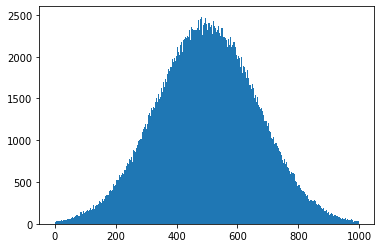

In [12]:
build_gassian_prototype()

In [13]:
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
                                    header=1,
                                    sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))

In [14]:
headers = dffema.columns
dummy_index = dffema.index[-1]+1
clean()
create_dates_index()
display(dffema)
dffema_len = len(dffema)
df_orig = None
df = None

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,187500.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,250000.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,500000.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,562500.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,1000000.00,0.00


In [15]:
def create_spend_report(colspend,display_result=True,save=False,
                        test_sums=False,n=0):
    global df
    # update single month
    df.loc[df["months"]==1,"spend"] = df[df["months"]==1][colspend]

    # update first month in multi-month
    criteria = (df["mindex"]==0) & (df["months"]>1)
    df.loc[criteria,"spend"] = \
    df[criteria].apply(lambda x: (round((cdf[x["fraction"]-1]/cdftot)*x[colspend],2)),axis=1)
    
    # update non-first months in multi-month
    criteria = (df["mindex"]>0) & (df["months"]>1)
    df.loc[criteria,"spend"] = \
        df[criteria].apply(lambda x: (round(((cdf[(x["mindex"]+1)*x["fraction"]-1] \
                                              - cdf[x["mindex"]*x["fraction"]-1])/cdftot)*x[colspend],2)),axis=1)

    # adjust "middle" element to compensate for rounding error
    tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
    df.loc[(df["months"]>1) \
                   & (df["mindex"] == (df["months"]/2).astype(int)),"spend"] += \
                        (df[(df["months"]>1) \
                                & (df["mindex"] \
                                   == (df["months"]/2).astype(int))][colspend] - tmp["spend"]).round(2)

    if test_sums:
        tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
        tmp2 = df[(df["months"]>1) & (df["mindex"]==1)]
        tmp3 = tmp2[((tmp2[colspend]-tmp["spend"]).abs().round(2))>0.0]
        if len(tmp3) != 0:
            print("The following rows failed the test...")
            display(tmp3)
        else:
            print("Passed!")
        

    # dispose of columns no longer needed
    df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
                          "STATE SPEND","months","mindex",
                          "fraction"],axis=1)

    # add dummy data, so that even date columns without data will be created
    # this row will not be included in final result since index will not match
    # any index in df_orig, but it will keep the columns, which is the point
    df = df.append(pd.DataFrame({"range":dti,"spend":0.0},
                                        index=np.ones(shape=len(dti),dtype=int)*dummy_index,
                                        columns=["range","spend"]))
    
    # pivot spend to date columns
    df = df.pivot(values="spend",columns="range")
    df.columns.name = ""
    
    # rejoin with original data
    df = df_orig.join(df)
    
    if display_result and not test_sums:
        display(df)

    if save and not test_sums:
        if colspend == "FED SPEND":
            filename = fema_fed_out_file
        elif colspend == "STATE SPEND":
            filename = fema_st_out_file
        else:
            filename = fema_tot_out_file
        # filepath = os.path.join(base_dir,filename+".csv")
        # fileexists = os.path.exists(filepath)
        # df.to_csv(filepath, header=(not fileexists), \
        #           mode=('a' if fileexists else 'w'))
        filepath = os.path.join(base_dir,F"{filename}_{n}.xlsx")
        df.to_excel(filepath, header=True)
        #df.to_excel(filepath, header=(n==0))
        print(F"file written to: {filepath}")

In [16]:
def prep(copy_orig=True):
    global df
    if copy_orig:
        df = df_orig.copy()

    # add range column (list of n months from start to end, formate YYYY-MM)
    dt1 = pd.to_datetime(df["START MO"].astype(str) + " " \
                         + df["START YR"].astype(str))
    dt2 = pd.to_datetime(df["END MO"].astype(str) + " " \
                         + df["END YR"].astype(str)) + MonthEnd(0)
    df["range"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() \
                   for a, b in zip(dt1, dt2)]

    # add months column (n, single number per row, not a list)
    df["months"] = df["range"].apply(len)

    # add mindex column (0 to n-1)
    df["mindex"] = df["months"].apply(np.arange)

    # add spend column (list of n 0.0's, placeholder for the calculated spend later
    df["spend"] = df["months"].apply(np.zeros)

    # drop all but the above 4 columns + index
    df = df.drop(["FUND SOURCE","TYPE","COUNTY","STATE","START YR",\
                  "START MO","END YR","END MO","NUMBER OF MONTHS"],axis=1)

    # explode date, index and spend (each is a list with n elements)
    df = df.explode(["range","mindex","spend"])
    df["spend"] = df["spend"].astype(float)

    # add fraction column
    df["fraction"] = ((1/df["months"]).astype(float) * cdfbins).astype(int)

In [17]:
if dffema_len > 0:
    n=0
    while True:
        df = dffema[(dffema.index >= n*chunk_size) \
                    & (dffema.index < (n+1)*chunk_size)].copy()
        if len(df) > 0:
            df_orig = df.copy()
            prep(copy_orig=False)
            create_spend_report("TOTAL PROJECT SPEND",save=True,n=n)
            prep()
            create_spend_report("FED SPEND",save=True,n=n)
            prep()
            create_spend_report("STATE SPEND",save=True,n=n)
        print(F"iteration {n+1}: {len(df)} records read")
        n += 1
        if n*chunk_size > (dffema_len-1):
            break

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,2664.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_0.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,1998.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_0.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,666.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_0.xlsx
iteration 1: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,22914.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_1.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,17185.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_1.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,5728.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_1.xlsx
iteration 2: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_2.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_2.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_2.xlsx
iteration 3: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_3.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_3.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_3.xlsx
iteration 4: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_4.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_4.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_4.xlsx
iteration 5: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
10,PUBLIC ASSISTANCE,Snowstorm,DuPage,IL,1999,1,1999,4,3,39048.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,PUBLIC ASSISTANCE,Snowstorm,DuPage,IL,1999,1,1999,4,3,40857.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_5.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
10,PUBLIC ASSISTANCE,Snowstorm,DuPage,IL,1999,1,1999,4,3,39048.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,PUBLIC ASSISTANCE,Snowstorm,DuPage,IL,1999,1,1999,4,3,40857.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_5.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
10,PUBLIC ASSISTANCE,Snowstorm,DuPage,IL,1999,1,1999,4,3,39048.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,PUBLIC ASSISTANCE,Snowstorm,DuPage,IL,1999,1,1999,4,3,40857.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_5.xlsx
iteration 6: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
12,PUBLIC ASSISTANCE,Snowstorm,Lake,IL,1999,1,1999,4,3,41600.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,PUBLIC ASSISTANCE,Snowstorm,Lake,IL,1999,1,1999,4,3,46506.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_6.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
12,PUBLIC ASSISTANCE,Snowstorm,Lake,IL,1999,1,1999,4,3,41600.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,PUBLIC ASSISTANCE,Snowstorm,Lake,IL,1999,1,1999,4,3,46506.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_6.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
12,PUBLIC ASSISTANCE,Snowstorm,Lake,IL,1999,1,1999,4,3,41600.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,PUBLIC ASSISTANCE,Snowstorm,Lake,IL,1999,1,1999,4,3,46506.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_6.xlsx
iteration 7: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
14,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,47668.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,53139.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_7.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
14,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,47668.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,53139.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_7.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
14,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,47668.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,53139.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_7.xlsx
iteration 8: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
16,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,55074.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,56010.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_8.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
16,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,55074.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,56010.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_8.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
16,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,55074.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,PUBLIC ASSISTANCE,Snowstorm,Cook,IL,1999,1,1999,4,3,56010.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_8.xlsx
iteration 9: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
18,PUBLIC ASSISTANCE,Severe Storm,Clark,WI,2010,10,2011,2,4,3720.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,PUBLIC ASSISTANCE,Severe Storm,Jackson,WI,2010,10,2011,2,4,3782.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_9.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
18,PUBLIC ASSISTANCE,Severe Storm,Clark,WI,2010,10,2011,2,4,3720.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,PUBLIC ASSISTANCE,Severe Storm,Jackson,WI,2010,10,2011,2,4,3782.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_9.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
18,PUBLIC ASSISTANCE,Severe Storm,Clark,WI,2010,10,2011,2,4,3720.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,PUBLIC ASSISTANCE,Severe Storm,Jackson,WI,2010,10,2011,2,4,3782.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_9.xlsx
iteration 10: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
20,PUBLIC ASSISTANCE,Severe Storm,Marathon,WI,2010,10,2011,2,4,3814.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PUBLIC ASSISTANCE,Severe Storm,Wood,WI,2010,10,2011,2,4,3834.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month_10.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
20,PUBLIC ASSISTANCE,Severe Storm,Marathon,WI,2010,10,2011,2,4,3814.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PUBLIC ASSISTANCE,Severe Storm,Wood,WI,2010,10,2011,2,4,3834.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_10.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
20,PUBLIC ASSISTANCE,Severe Storm,Marathon,WI,2010,10,2011,2,4,3814.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PUBLIC ASSISTANCE,Severe Storm,Wood,WI,2010,10,2011,2,4,3834.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month_10.xlsx
iteration 11: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
22,PUBLIC ASSISTANCE,Hurricane,Ocean,NJ,2012,10,2013,3,5,22277.32,...,NaN,NaN,NaN,NaN,466.38,3000.96,7548.69,7645.52,3114.08,501.69
23,PUBLIC ASSISTANCE,Hurricane,Hunterdon,NJ,2012,10,2013,3,5,22330.99,...,NaN,NaN,NaN,NaN,467.50,3008.19,7566.88,7663.95,3121.58,502.89


file written to: /content/drive/MyDrive/environment/fema_total_by_month_11.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
22,PUBLIC ASSISTANCE,Hurricane,Ocean,NJ,2012,10,2013,3,5,22277.32,...,NaN,NaN,NaN,NaN,419.74,2700.86,6793.82,6880.98,2802.67,451.52
23,PUBLIC ASSISTANCE,Hurricane,Hunterdon,NJ,2012,10,2013,3,5,22330.99,...,NaN,NaN,NaN,NaN,420.75,2707.37,6810.19,6897.56,2809.42,452.60


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_11.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
22,PUBLIC ASSISTANCE,Hurricane,Ocean,NJ,2012,10,2013,3,5,22277.32,...,NaN,NaN,NaN,NaN,46.64,300.10,754.87,764.54,311.41,50.17
23,PUBLIC ASSISTANCE,Hurricane,Hunterdon,NJ,2012,10,2013,3,5,22330.99,...,NaN,NaN,NaN,NaN,46.75,300.82,756.69,766.39,312.16,50.29


file written to: /content/drive/MyDrive/environment/fema_state_by_month_11.xlsx
iteration 12: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
24,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2012,10,2013,3,5,22369.56,...,NaN,NaN,NaN,NaN,468.31,3013.38,7579.95,7677.19,3126.97,503.76
25,PUBLIC ASSISTANCE,Hurricane,Warren,NJ,2012,10,2013,3,5,22445.56,...,NaN,NaN,NaN,NaN,469.90,3023.62,7605.70,7703.27,3137.60,505.47


file written to: /content/drive/MyDrive/environment/fema_total_by_month_12.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
24,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2012,10,2013,3,5,22369.56,...,NaN,NaN,NaN,NaN,421.48,2712.04,6821.95,6909.46,2814.28,453.39
25,PUBLIC ASSISTANCE,Hurricane,Warren,NJ,2012,10,2013,3,5,22445.56,...,NaN,NaN,NaN,NaN,422.91,2721.26,6845.13,6932.93,2823.84,454.93


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_12.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
24,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2012,10,2013,3,5,22369.56,...,NaN,NaN,NaN,NaN,46.83,301.34,758.00,767.71,312.70,50.38
25,PUBLIC ASSISTANCE,Hurricane,Warren,NJ,2012,10,2013,3,5,22445.56,...,NaN,NaN,NaN,NaN,46.99,302.36,760.57,770.33,313.76,50.55


file written to: /content/drive/MyDrive/environment/fema_state_by_month_12.xlsx
iteration 13: 2 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
26,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2012,10,2013,3,5,23079.68,...,NaN,NaN,NaN,NaN,483.17,3109.04,7820.57,7920.91,3226.24,519.75


file written to: /content/drive/MyDrive/environment/fema_total_by_month_13.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
26,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2012,10,2013,3,5,23079.68,...,NaN,NaN,NaN,NaN,434.86,2798.14,7038.51,7128.8,2903.62,467.78


file written to: /content/drive/MyDrive/environment/fema_fed_by_month_13.xlsx


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
26,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2012,10,2013,3,5,23079.68,...,NaN,NaN,NaN,NaN,48.32,310.9,782.06,792.09,322.62,51.98


file written to: /content/drive/MyDrive/environment/fema_state_by_month_13.xlsx
iteration 14: 1 records read


In [18]:
def merge_excel_files(filename):
    #file_list = glob.glob(path + "/*.xlsx")
    file_list = glob.glob(os.path.join(base_dir,F"{filename}*.xlsx"))
    excl_list = []
    for file in file_list:
        excl_list.append(pd.read_excel(file))
    excl_merged = pd.DataFrame()
    for excl_file in excl_list:
        # appends the data into the excl_merged
        # dataframe.
        excl_merged = excl_merged.append(
            excl_file, ignore_index=True)
    excl_merged.drop(columns=excl_merged.columns[0], axis=1, inplace=True)
    #display(excl_merged)
    # exports the dataframe into excel file with
    # specified name.
    excl_merged.to_excel(os.path.join(base_dir,F"{filename}.xlsx"))

In [19]:
print(F"{n-1} files per type need to be merged")
merge_excel_files(fema_fed_out_file)
merge_excel_files(fema_st_out_file)
merge_excel_files(fema_tot_out_file)

13 files per type need to be merged


In [20]:
clean_up_excel_files(fema_fed_out_file)
clean_up_excel_files(fema_st_out_file)
clean_up_excel_files(fema_tot_out_file)

removing /content/drive/MyDrive/environment/fema_fed_by_month_0.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_1.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_2.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_3.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_4.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_5.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_6.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_7.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_8.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_9.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_10.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_11.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_12.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month

In [21]:
# def convert_to_xslx(filename,remove_file=False):
#     filepath_csv = os.path.join(base_dir,F"{filename}.csv")
#     print(F"checking existence of {filepath_csv}")
#     if os.path.exists(filepath_csv):
#         print(F"converting {filepath_csv}")
#         tmp = pd.read_csv(filepath_csv)
#         tmp.to_excel(os.path.join(base_dir, F"{filename}.xlsx"), header=True)
#         if remove_file:
#             os.remove(filepath_csv)

In [22]:
#convert_to_xslx(F"{fema_fed_out_file}_float")
#convert_to_xslx(F"{fema_st_out_file}_float")
#convert_to_xslx(F"{fema_tot_out_file}_float")
#convert_to_xslx("tmp")

In [23]:
#!cat /content/drive/MyDrive/environment/fema_fed_by_month.csv
#!cat /content/drive/MyDrive/environment/fema_state_by_month.csv
#!cat /content/drive/MyDrive/environment/fema_total_by_month.csv
#!head -n60 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!head -n60 /content/drive/MyDrive/environment/fema_state_by_month_float.csv
#!head -n60 /content/drive/MyDrive/environment/fema_total_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_state_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_total_by_month_float.csv
#!tail -n60 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
# 950504
# 950504 - 55 = 950449
#!head /content/drive/MyDrive/environment/fema_fed_by_month.csv
#!head /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!head -n1 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv > /content/drive/MyDrive/environment/tmp.csv
#!tail -n950449 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv >> /content/drive/MyDrive/environment/tmp.csv
#!head /content/drive/MyDrive/environment/tmp.csv